## IMPORTING LIBRARIES

In [8]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import  seaborn as sns

# PCA & Hyper Tuning
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split

# Transformers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from collections import Counter

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
import joblib

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## SCORE RESULTS DATAFRAME

In [2]:
model_scores_df = pd.DataFrame(columns=['Model','Data','Accuracy', 'F1 Score'])
model_scores_df['Accuracy'].astype(float)
model_scores_df['F1 Score'].astype(float)

Series([], Name: F1 Score, dtype: float64)

In [3]:
def update_model_scores(model, model_name, data_name, X_test, y_test):
    global model_scores_df

    predictions = model.predict(X_test)
    
    acc = accuracy_score(y_test, predictions)

    f1 = f1_score(y_test, predictions, average="weighted")
    
    acc_formatted = round(acc, 3)
    f1_formatted = round(f1, 3)
    
    new_entry = pd.DataFrame({'Model': [model_name],'Data':[data_name], 'Accuracy': [acc_formatted], 'F1 Score': [f1_formatted]})
    
    model_scores_df = pd.concat([model_scores_df, new_entry], ignore_index=True)

    print("For the model name: ", model_name, "  Accuracy is: ", acc_formatted)
    print("For the model name: ", model_name, "  F1 Score is: ", f1_formatted)

## FEATURE ENGINEERING

> ***Load Data and print its Shapes***

In [4]:
df = pd.read_csv('no_outliers.csv')

In [5]:
df.columns

Index(['Unnamed: 0', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [6]:
df = df.drop(columns=['Unnamed: 0'])

> ***See Correlation between features***

In [7]:
categorical_columns = ["Gender", "Vehicle_Damage", "Vehicle_Age"]

encoder = OneHotEncoder(sparse_output=False)
encoded_df = pd.DataFrame(encoder.fit_transform(df[categorical_columns]))

encoded_df.index = df.index

encoded_df.columns = encoder.get_feature_names_out(categorical_columns)

numerical_df = df.drop(columns=categorical_columns)

df_transformed = pd.concat([numerical_df, encoded_df], axis=1)

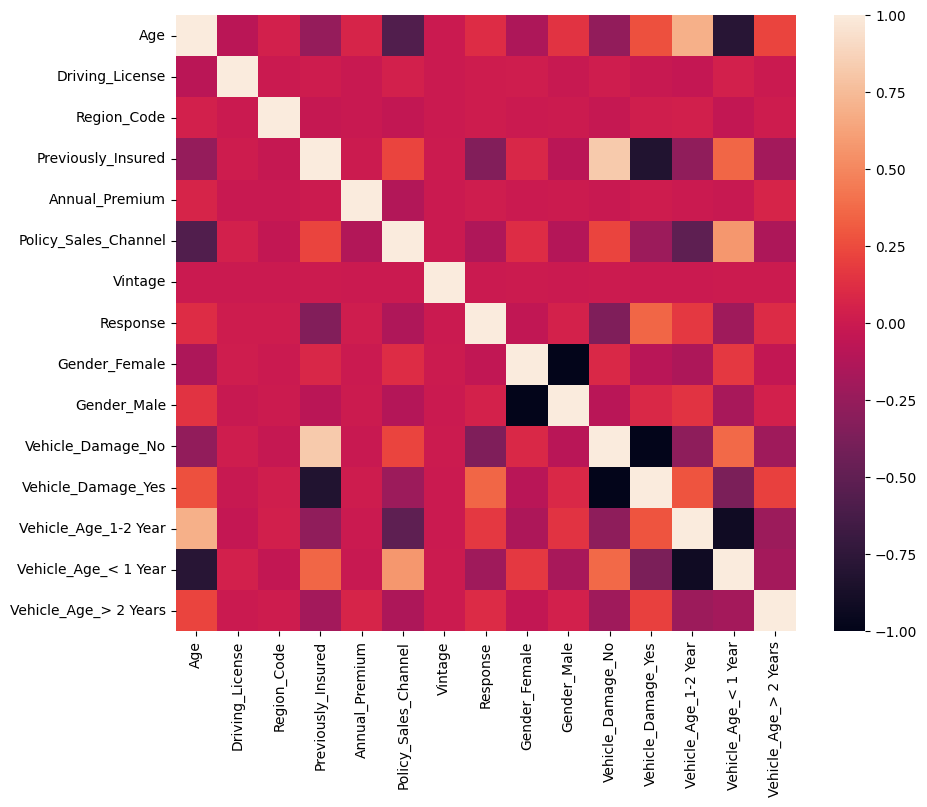

In [8]:
plt.figure(figsize=(10,8))

corr = df_transformed.corr()
sns.heatmap(corr, annot_kws={'size':20})
plt.show()

In [9]:
X = df.drop(columns=['Response'])
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)
print(f"Original dataset shape: {Counter(y)}")
print(f"Training set shape: {Counter(y_train)}")
print(f"Test set shape: {Counter(y_test)}")

X_train Shape: (265318, 10)
y_train Shape: (265318,)
X_test Shape: (113708, 10)
y_test Shape: (113708,)
Original dataset shape: Counter({0: 332638, 1: 46388})
Training set shape: Counter({0: 232846, 1: 32472})
Test set shape: Counter({0: 99792, 1: 13916})


In [10]:
X_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
375643,Female,26,1,15.0,1,< 1 Year,No,2630.0,152.0,157
186701,Male,22,1,41.0,1,< 1 Year,Yes,34038.0,152.0,170
102439,Male,27,1,14.0,1,< 1 Year,No,30760.0,152.0,155
218594,Male,57,1,33.0,1,1-2 Year,No,28980.0,26.0,192
102090,Female,62,1,28.0,1,1-2 Year,No,33708.0,125.0,291


## PreProcessing

> ***Missing Values ration and unique values in each column***

In [11]:
info_df = pd.DataFrame()
info_df['missing_val'] = X_train.isnull().sum()
info_df['missing_val_ratio'] = (info_df['missing_val'] / X_train.shape[0] * 100).round(3)

info_df = info_df.sort_values(by='missing_val_ratio', ascending=False)
print(X_train.shape)

info_df.head(20)

(265318, 10)


,missing_val,missing_val_ratio
Gender,0,0.0
Age,0,0.0
Driving_License,0,0.0
Region_Code,0,0.0
Previously_Insured,0,0.0
Vehicle_Age,0,0.0
Vehicle_Damage,0,0.0
Annual_Premium,0,0.0
Policy_Sales_Channel,0,0.0
Vintage,0,0.0


In [12]:
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print('numerical_features_shape : ' + str(len(numerical_features)))
print('categorical_features_shape : ' + str(len(categorical_features)))

print(numerical_features)
print(categorical_features)

numerical_features_shape : 7
categorical_features_shape : 3
['Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
['Gender', 'Vehicle_Age', 'Vehicle_Damage']


In [13]:
X_train[numerical_features].nunique()

Age                        66
Driving_License             2
Region_Code                53
Previously_Insured          2
Annual_Premium          43645
Policy_Sales_Channel      154
Vintage                   290
dtype: int64

In [14]:
X_train[categorical_features].nunique()

Gender            2
Vehicle_Age       3
Vehicle_Damage    2
dtype: int64

>***Initializing PreProcession***

Gender, Vehicle_Damage, Vehicle_Age, Region_Code and Policy_Sales_Channel attributes are categorical variables even though Region_Code and Policy_Sales_Channel are defined as floats.

In [15]:
numerical_features = ['Age', 'Annual_Premium', 'Vintage']
categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse=False,handle_unknown='ignore'), categorical_features)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [16]:
X_transformed = pipeline.fit_transform(X_train)

X_train_transformed = pd.DataFrame(X_transformed, columns=pipeline.named_steps['preprocessor'].get_feature_names_out())

In [17]:
print(X_train_transformed.shape)
X_train_transformed.head()

(265318, 217)


,num__Age,num__Annual_Premium,num__Vintage,cat__Gender_Female,cat__Gender_Male,cat__Vehicle_Age_1-2 Year,cat__Vehicle_Age_< 1 Year,cat__Vehicle_Age_> 2 Years,cat__Vehicle_Damage_No,cat__Vehicle_Damage_Yes,...,cat__Policy_Sales_Channel_152.0,cat__Policy_Sales_Channel_153.0,cat__Policy_Sales_Channel_154.0,cat__Policy_Sales_Channel_155.0,cat__Policy_Sales_Channel_156.0,cat__Policy_Sales_Channel_157.0,cat__Policy_Sales_Channel_158.0,cat__Policy_Sales_Channel_159.0,cat__Policy_Sales_Channel_160.0,cat__Policy_Sales_Channel_163.0
0,0.092308,0.000000,0.508651,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.030769,0.394746,0.553633,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.107692,0.353547,0.501730,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.569231,0.331176,0.629758,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.646154,0.390599,0.972318,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
print(X_train_transformed.columns)

Index(['num__Age', 'num__Annual_Premium', 'num__Vintage', 'cat__Gender_Female',
       'cat__Gender_Male', 'cat__Vehicle_Age_1-2 Year',
       'cat__Vehicle_Age_< 1 Year', 'cat__Vehicle_Age_> 2 Years',
       'cat__Vehicle_Damage_No', 'cat__Vehicle_Damage_Yes',
       ...
       'cat__Policy_Sales_Channel_152.0', 'cat__Policy_Sales_Channel_153.0',
       'cat__Policy_Sales_Channel_154.0', 'cat__Policy_Sales_Channel_155.0',
       'cat__Policy_Sales_Channel_156.0', 'cat__Policy_Sales_Channel_157.0',
       'cat__Policy_Sales_Channel_158.0', 'cat__Policy_Sales_Channel_159.0',
       'cat__Policy_Sales_Channel_160.0', 'cat__Policy_Sales_Channel_163.0'],
      dtype='object', length=217)


In [19]:
X_train_transformed.isnull().sum().any()

False

In [20]:
X_t_transformed = pipeline.transform(X_test)
X_test_transformed = pd.DataFrame(X_t_transformed, columns=pipeline.named_steps['preprocessor'].get_feature_names_out())

In [21]:
print(X_test_transformed.shape)
X_test_transformed.head()

(113708, 217)


,num__Age,num__Annual_Premium,num__Vintage,cat__Gender_Female,cat__Gender_Male,cat__Vehicle_Age_1-2 Year,cat__Vehicle_Age_< 1 Year,cat__Vehicle_Age_> 2 Years,cat__Vehicle_Damage_No,cat__Vehicle_Damage_Yes,...,cat__Policy_Sales_Channel_152.0,cat__Policy_Sales_Channel_153.0,cat__Policy_Sales_Channel_154.0,cat__Policy_Sales_Channel_155.0,cat__Policy_Sales_Channel_156.0,cat__Policy_Sales_Channel_157.0,cat__Policy_Sales_Channel_158.0,cat__Policy_Sales_Channel_159.0,cat__Policy_Sales_Channel_160.0,cat__Policy_Sales_Channel_163.0
0,0.276923,0.323836,0.858131,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.292308,0.394143,0.740484,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.123077,0.308729,0.982699,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.092308,0.344511,0.446367,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.553846,0.498058,0.152249,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> ***Saving Transformed datasets***

In [22]:
X_train_transformed = X_train_transformed.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

resampled_data = pd.DataFrame(X_train_transformed)
resampled_data['Response'] = y_train

In [23]:
# Save the DataFrame to a CSV file
resampled_data.to_csv('no_outliers_transformed_train_data.csv', index=False)

In [24]:
X_test_transformed = X_test_transformed.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

resampled_data2 = pd.DataFrame(X_test_transformed)
resampled_data2['Response'] = y_test

In [25]:
# Save the DataFrame to a CSV file
resampled_data2.to_csv('no_outliers_transformed_test_data.csv', index=False)

## OverSampling

In [26]:
print(f"Original dataset shape: {Counter(y_train)}")

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

# After oversampling
print(f"Resampled dataset shape: {Counter(y_train_res)}")

Original dataset shape: Counter({0: 232846, 1: 32472})
Resampled dataset shape: Counter({0: 232846, 1: 232846})


In [27]:
X_train_res = X_train_res.reset_index(drop=True)
y_train_res = y_train_res.reset_index(drop=True)

resampled_data = pd.DataFrame(X_train_res)
resampled_data['Response'] = y_train_res

# Save the DataFrame to a CSV file
resampled_data.to_csv('over_sampled_no_outliers_train_data.csv', index=False)

print("Resampled dataset saved as 'resampled_train_data.csv'")

Resampled dataset saved as 'resampled_train_data.csv'


## UnderSampling

In [28]:
print(f"Original dataset shape: {Counter(y_train)}")

undersampler = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = undersampler.fit_resample(X_train_transformed, y_train)

# After undersampling
print(f"Resampled dataset shape: {Counter(y_train_res)}")

Original dataset shape: Counter({0: 232846, 1: 32472})
Resampled dataset shape: Counter({0: 32472, 1: 32472})


In [29]:
X_train_res = X_train_res.reset_index(drop=True)
y_train_res = y_train_res.reset_index(drop=True)

resampled_data = pd.DataFrame(X_train_res)
resampled_data['Response'] = y_train_res

# Save the DataFrame to a CSV file
resampled_data.to_csv('under_sampled_no_outliers_train_data.csv', index=False)

print("Resampled dataset saved as 'resampled_train_data.csv'")

Resampled dataset saved as 'resampled_train_data.csv'


## FEATURE SELECTION

We decided to take the oversampling approach first then we will try the undersampling

In [30]:
df_over_sampled_train = pd.read_csv('over_sampled_no_outliers_train_data.csv')
df_under_sampled_train = pd.read_csv('under_sampled_no_outliers_train_data.csv')

X_over_sampled_train = df_over_sampled_train.drop(columns=['Response'])
y_over_sampled_train = df_over_sampled_train['Response']

X_under_sampled_train = df_under_sampled_train.drop(columns=['Response'])
y_under_sampled_train = df_under_sampled_train['Response']

df_test = pd.read_csv('no_outliers_transformed_test_data.csv')

X_test = df_test.drop(columns=['Response'])
y_test = df_test['Response']

> ***select features from oversampled dataset***

In [31]:
select_model_based = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="mean")

# fit on training data
select_model_based.fit(X_over_sampled_train, y_over_sampled_train)

# transform training data
X_over_sampled_train_reduced = select_model_based.transform(X_over_sampled_train)

# transform testing data
X_test_reduced = select_model_based.transform(X_test)

print("New data shape: ", X_over_sampled_train_reduced.shape)

New data shape:  (465692, 12)


In [32]:
X_over_sampled_train_reduced_df = pd.DataFrame(X_over_sampled_train_reduced, columns=select_model_based.get_feature_names_out())
X_test_reduced_df = pd.DataFrame(X_test_reduced, columns=select_model_based.get_feature_names_out())
X_test_reduced_df.head()

,num__Age,num__Annual_Premium,num__Vintage,cat__Vehicle_Age_1-2 Year,cat__Vehicle_Age_< 1 Year,cat__Vehicle_Damage_No,cat__Vehicle_Damage_Yes,cat__Region_Code_28.0,cat__Policy_Sales_Channel_26.0,cat__Policy_Sales_Channel_124.0,cat__Policy_Sales_Channel_152.0,cat__Policy_Sales_Channel_160.0
0,0.276923,0.323836,0.858131,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.292308,0.394143,0.740484,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.123077,0.308729,0.982699,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.092308,0.344511,0.446367,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,0.553846,0.498058,0.152249,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


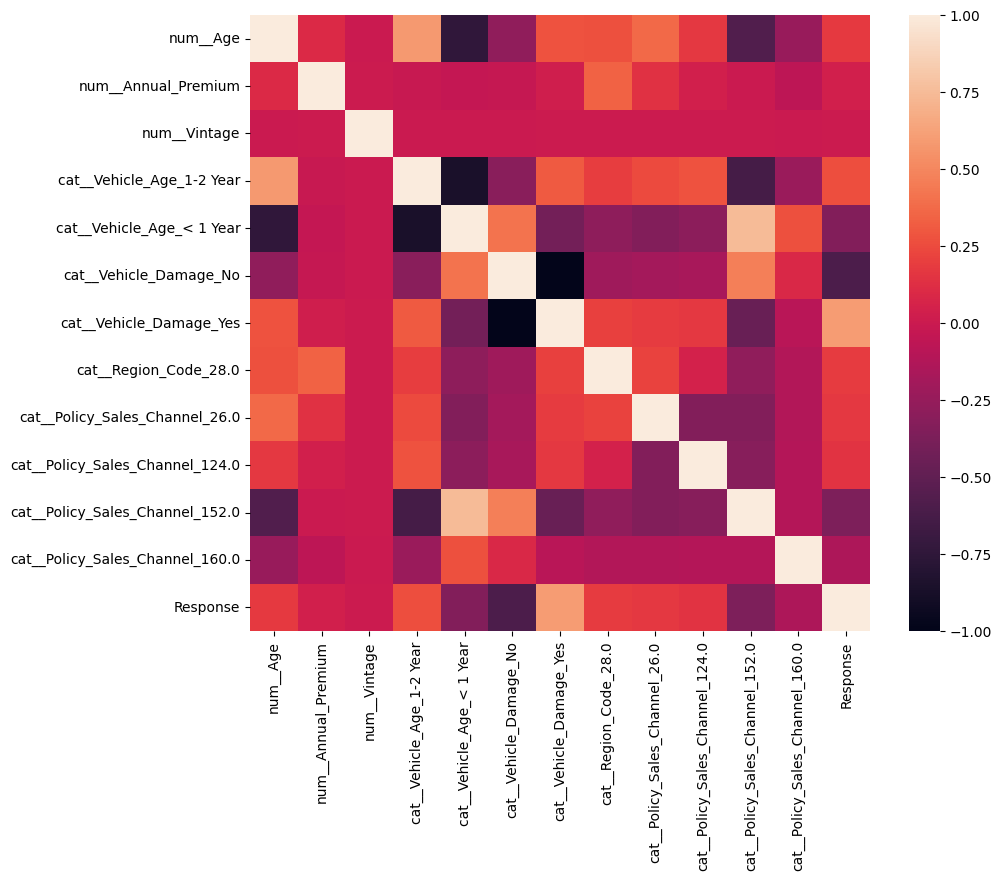

In [33]:
new_df = X_over_sampled_train_reduced_df.copy()
new_df["Response"] = y_over_sampled_train

plt.figure(figsize=(10,8))

corr = new_df.corr()
sns.heatmap(corr, annot_kws={'size':20})
plt.show()

> ***select features from undersampled dataset***

In [34]:
select_model_based = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="mean")

# fit on training data
select_model_based.fit(X_under_sampled_train, y_under_sampled_train)

# transform training data
X_under_sampled_train_reduced = select_model_based.transform(X_under_sampled_train)

# transform testing data
X_under_sampled_test_reduced = select_model_based.transform(X_test)

print("New data shape: ", X_under_sampled_train_reduced.shape)

New data shape:  (64944, 15)


In [35]:
X_under_sampled_train_reduced_df = pd.DataFrame(X_under_sampled_train_reduced, columns=select_model_based.get_feature_names_out())
X_under_sampled_test_reduced_df = pd.DataFrame(X_under_sampled_test_reduced, columns=select_model_based.get_feature_names_out())
X_under_sampled_test_reduced_df.head()

,num__Age,num__Annual_Premium,num__Vintage,cat__Gender_Female,cat__Gender_Male,cat__Vehicle_Age_1-2 Year,cat__Vehicle_Age_< 1 Year,cat__Vehicle_Age_> 2 Years,cat__Vehicle_Damage_No,cat__Vehicle_Damage_Yes,cat__Region_Code_28.0,cat__Policy_Sales_Channel_26.0,cat__Policy_Sales_Channel_124.0,cat__Policy_Sales_Channel_152.0,cat__Policy_Sales_Channel_160.0
0,0.276923,0.323836,0.858131,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.292308,0.394143,0.740484,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.123077,0.308729,0.982699,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.092308,0.344511,0.446367,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,0.553846,0.498058,0.152249,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


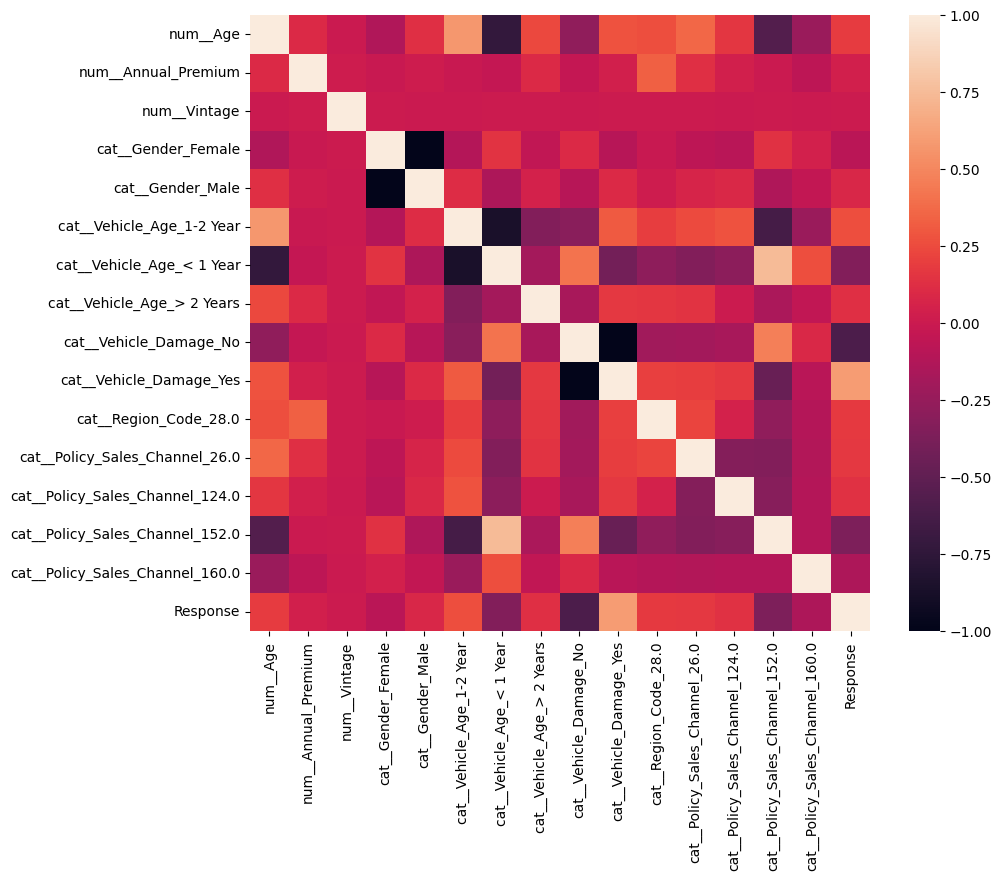

In [36]:
new_df = X_under_sampled_train_reduced_df.copy()
new_df["Response"] = y_under_sampled_train

plt.figure(figsize=(10,8))

corr = new_df.corr()
sns.heatmap(corr, annot_kws={'size':20})
plt.show()

## PCA

Text(0, 0.5, 'cumulative explained variance')

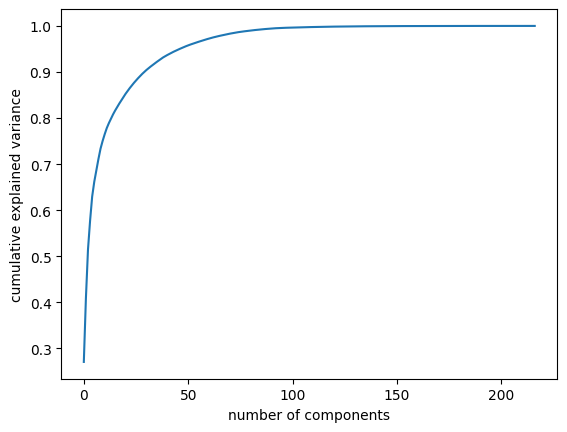

In [37]:
pca = PCA().fit(X_train_transformed)

plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

> ***Train & Test Transformation.***

In [38]:
pca = PCA(n_components= 50)
pca_data_train = pca.fit_transform(X_train_transformed)
pca_data_test = pca.transform(X_test_transformed)

## MODELS

In [39]:
def get_result(model, model_name, data_name, X_train, X_test, y_train, y_test):
    train_data_acc_score = accuracy_score(y_train, model.predict(X_train))
    print("Train acc score", train_data_acc_score, "\n")
    y_pred = model.predict(X_test)
    print("Test  acc score", accuracy_score(y_test, y_pred), "\n")
    print(classification_report(y_test, y_pred))
    update_model_scores(model, model_name, data_name, X_test, y_test)

### LOGISTIC REGRESSION

#### Preprocessed Data

In [40]:
param_grid = {}

log_reg = LogisticRegression(n_jobs = -1, max_iter = 1000)

grid_search = GridSearchCV(log_reg, param_grid)

In [41]:
grid_search.fit(X_train_transformed, y_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Model: LogisticRegression(max_iter=1000, n_jobs=-1)
Best Parameters: {}
Best Score: 0.8774150262445575


In [42]:
get_result(grid_search.best_estimator_, "LogisticRegression", "Preprocessed Data", X_train_transformed, X_test_transformed, y_train, y_test)

Train acc score 0.8774677933649432 

Test  acc score 0.8775284060927991 

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     99792
           1       0.40      0.00      0.00     13916

    accuracy                           0.88    113708
   macro avg       0.64      0.50      0.47    113708
weighted avg       0.82      0.88      0.82    113708

For the model name:  LogisticRegression   Accuracy is:  0.878
For the model name:  LogisticRegression   F1 Score is:  0.821


#### Oversampled Data

In [43]:
param_grid = {}

log_reg = LogisticRegression(n_jobs = -1, max_iter = 1000)

grid_search = GridSearchCV(log_reg, param_grid)

In [44]:
grid_search.fit(X_over_sampled_train_reduced_df, y_over_sampled_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Model: LogisticRegression(max_iter=1000, n_jobs=-1)
Best Parameters: {}
Best Score: 0.7805008495372615


In [45]:
get_result(grid_search.best_estimator_, "LogisticRegression", "Oversampled Data", X_over_sampled_train_reduced_df, X_test_reduced_df, y_over_sampled_train, y_test)

Train acc score 0.7807048435446604 

Test  acc score 0.6775248883104091 

              precision    recall  f1-score   support

           0       0.98      0.64      0.78     99792
           1       0.26      0.92      0.41     13916

    accuracy                           0.68    113708
   macro avg       0.62      0.78      0.59    113708
weighted avg       0.89      0.68      0.73    113708

For the model name:  LogisticRegression   Accuracy is:  0.678
For the model name:  LogisticRegression   F1 Score is:  0.733


#### Undersampled Data

In [46]:
param_grid = {}

log_reg = LogisticRegression(n_jobs = -1, max_iter = 1000)

grid_search = GridSearchCV(log_reg, param_grid)

In [47]:
grid_search.fit(X_under_sampled_train_reduced_df, y_under_sampled_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Model: LogisticRegression(max_iter=1000, n_jobs=-1)
Best Parameters: {}
Best Score: 0.7841678726850511


In [48]:
get_result(grid_search.best_estimator_, "LogisticRegression", "Undersampled Data", X_under_sampled_train_reduced_df, X_under_sampled_test_reduced_df, y_under_sampled_train, y_test)

Train acc score 0.7840447154471545 

Test  acc score 0.6805325922538432 

              precision    recall  f1-score   support

           0       0.98      0.65      0.78     99792
           1       0.27      0.92      0.41     13916

    accuracy                           0.68    113708
   macro avg       0.62      0.78      0.60    113708
weighted avg       0.89      0.68      0.74    113708

For the model name:  LogisticRegression   Accuracy is:  0.681
For the model name:  LogisticRegression   F1 Score is:  0.736


#### PCA Data

In [49]:
param_grid = {}

log_reg = LogisticRegression(n_jobs = -1, max_iter = 1000)

grid_search = GridSearchCV(log_reg, param_grid)

In [50]:
grid_search.fit(pca_data_train, y_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Model: LogisticRegression(max_iter=1000, n_jobs=-1)
Best Parameters: {}
Best Score: 0.8773283374058615


In [51]:
get_result(grid_search.best_estimator_, "LogisticRegression", "PCA Data", pca_data_train, pca_data_test, y_train, y_test)

Train acc score 0.8773396452558816 

Test  acc score 0.8774668449009744 

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     99792
           1       0.38      0.00      0.00     13916

    accuracy                           0.88    113708
   macro avg       0.63      0.50      0.47    113708
weighted avg       0.82      0.88      0.82    113708

For the model name:  LogisticRegression   Accuracy is:  0.877
For the model name:  LogisticRegression   F1 Score is:  0.821


### NAIVE BAYES

#### Preprocessed Data

In [52]:
param_grid = {
    'var_smoothing': np.logspace(-9, 0, 10)
}

gnb = GaussianNB()

grid_search = GridSearchCV(gnb, param_grid, refit=True, verbose=2, cv=5)

In [53]:
grid_search.fit(X_train_transformed, y_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ................................var_smoothing=1e-09; total time=   0.9s
[CV] END ................................var_smoothing=1e-09; total time=   0.9s
[CV] END ................................var_smoothing=1e-09; total time=   1.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.9s
[CV] END ................................var_smoothing=1e-09; total time=   1.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.9s
[CV] END ................................var_smoothing=1e-08; total time=   1.0s
[CV] END ................................var_smoothing=1e-08; total time=   1.0s
[CV] END ................................var_smoothing=1e-08; total time=   1.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.9s
[CV] END ................................var_smoothing=1e-07; total time=   0.9s
[CV] END ................................var_smo

In [54]:
get_result(grid_search.best_estimator_, "NAIVE BAYES", "Preprocessed Data", X_train_transformed, X_test_transformed, y_train, y_test)

Train acc score 0.7303763785344379 

Test  acc score 0.7307665247827769 

              precision    recall  f1-score   support

           0       0.96      0.72      0.83     99792
           1       0.28      0.78      0.41     13916

    accuracy                           0.73    113708
   macro avg       0.62      0.75      0.62    113708
weighted avg       0.88      0.73      0.77    113708

For the model name:  NAIVE BAYES   Accuracy is:  0.731
For the model name:  NAIVE BAYES   F1 Score is:  0.775


#### Oversampled Data

In [55]:
param_grid = {
    'var_smoothing': np.logspace(-9, 0, 10)
}

gnb = GaussianNB()

grid_search = GridSearchCV(gnb, param_grid, refit=True, verbose=2, cv=5)

In [56]:
grid_search.fit(X_over_sampled_train_reduced_df, y_over_sampled_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-07; total time=   0.0s
[CV] END ................................var_smo

In [57]:
get_result(grid_search.best_estimator_, "NAIVE BAYES", "Oversampled Data", X_over_sampled_train_reduced_df, X_test_reduced_df, y_over_sampled_train, y_test)

Train acc score 0.7808422734339434 

Test  acc score 0.6919126182854328 

              precision    recall  f1-score   support

           0       0.98      0.66      0.79     99792
           1       0.27      0.90      0.42     13916

    accuracy                           0.69    113708
   macro avg       0.63      0.78      0.60    113708
weighted avg       0.89      0.69      0.74    113708

For the model name:  NAIVE BAYES   Accuracy is:  0.692
For the model name:  NAIVE BAYES   F1 Score is:  0.745


#### Undersampled Data

In [58]:
param_grid = {
    'var_smoothing': np.logspace(-9, 0, 10)
}

gnb = GaussianNB()

grid_search = GridSearchCV(gnb, param_grid, refit=True, verbose=2, cv=5)

In [59]:
grid_search.fit(X_under_sampled_train_reduced_df, y_under_sampled_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-07; total time=   0.0s
[CV] END ................................var_smo

In [60]:
get_result(grid_search.best_estimator_, "NAIVE BAYES", "Undersampled Data", X_under_sampled_train_reduced_df, X_under_sampled_test_reduced_df, y_under_sampled_train, y_test)

Train acc score 0.7832594235033259 

Test  acc score 0.6931086642980265 

              precision    recall  f1-score   support

           0       0.98      0.66      0.79     99792
           1       0.27      0.90      0.42     13916

    accuracy                           0.69    113708
   macro avg       0.63      0.78      0.60    113708
weighted avg       0.89      0.69      0.75    113708

For the model name:  NAIVE BAYES   Accuracy is:  0.693
For the model name:  NAIVE BAYES   F1 Score is:  0.746


#### PCA Data

In [61]:
param_grid = {
    'var_smoothing': np.logspace(-9, 0, 10)
}

gnb = GaussianNB()

grid_search = GridSearchCV(gnb, param_grid, refit=True, verbose=2, cv=5)

In [62]:
grid_search.fit(pca_data_train, y_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-09; total time=   0.2s
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.2s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-07; total time=   0.1s
[CV] END ................................var_smo

In [63]:
get_result(grid_search.best_estimator_, "NAIVE BAYES", "PCA Data", pca_data_train, pca_data_test, y_train, y_test)

Train acc score 0.8776110177221297 

Test  acc score 0.8776163506525486 

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     99792
           1       0.00      0.00      0.00     13916

    accuracy                           0.88    113708
   macro avg       0.44      0.50      0.47    113708
weighted avg       0.77      0.88      0.82    113708

For the model name:  NAIVE BAYES   Accuracy is:  0.878
For the model name:  NAIVE BAYES   F1 Score is:  0.82


### KNN

#### Preprocessed Data

In [64]:
param_grid = {
    'n_neighbors': [3, 5],
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, n_jobs=-1)

In [65]:
grid_search.fit(X_train_transformed, y_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Model: KNeighborsClassifier()
Best Parameters: {'n_neighbors': 5}
Best Score: 0.8567944849861853


In [66]:
get_result(grid_search.best_estimator_, "K-Nearest Neighbors (KNN)", "Preprocessed Data", X_train_transformed, X_test_transformed, y_train, y_test)

Train acc score 0.8967088550343362 

Test  acc score 0.8560963168818377 

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     99792
           1       0.33      0.17      0.22     13916

    accuracy                           0.86    113708
   macro avg       0.61      0.56      0.57    113708
weighted avg       0.82      0.86      0.84    113708

For the model name:  K-Nearest Neighbors (KNN)   Accuracy is:  0.856
For the model name:  K-Nearest Neighbors (KNN)   F1 Score is:  0.835


#### Oversampled Data

In [67]:
param_grid = {
    'n_neighbors': [3, 5, 10],
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid)

In [68]:
grid_search.fit(X_over_sampled_train_reduced_df, y_over_sampled_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Model: KNeighborsClassifier(n_neighbors=3)
Best Parameters: {'n_neighbors': 3}
Best Score: 0.8117554157985003


In [69]:
get_result(grid_search.best_estimator_, "K-Nearest Neighbors (KNN)", "Oversampled Data", X_over_sampled_train_reduced_df, X_test_reduced_df, y_over_sampled_train, y_test)

Train acc score 0.8986175412074934 

Test  acc score 0.7462359728427199 

              precision    recall  f1-score   support

           0       0.94      0.76      0.84     99792
           1       0.27      0.63      0.38     13916

    accuracy                           0.75    113708
   macro avg       0.60      0.70      0.61    113708
weighted avg       0.86      0.75      0.78    113708

For the model name:  K-Nearest Neighbors (KNN)   Accuracy is:  0.746
For the model name:  K-Nearest Neighbors (KNN)   F1 Score is:  0.784


#### Undersampled Data

In [70]:
param_grid = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5)

In [71]:
grid_search.fit(X_under_sampled_train_reduced_df, y_under_sampled_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Model: KNeighborsClassifier(metric='euclidean', n_neighbors=10, weights='distance')
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
Best Score: 0.7678615375266125


In [72]:
get_result(grid_search.best_estimator_, "K-Nearest Neighbors (KNN)", "Undersampled Data", X_under_sampled_train_reduced_df, X_under_sampled_test_reduced_df, y_under_sampled_train, y_test)

Train acc score 0.9984294161123429 

Test  acc score 0.6982094487634994 

              precision    recall  f1-score   support

           0       0.97      0.68      0.80     99792
           1       0.27      0.85      0.41     13916

    accuracy                           0.70    113708
   macro avg       0.62      0.76      0.60    113708
weighted avg       0.88      0.70      0.75    113708

For the model name:  K-Nearest Neighbors (KNN)   Accuracy is:  0.698
For the model name:  K-Nearest Neighbors (KNN)   F1 Score is:  0.75


#### PCA Data

In [73]:
param_grid = {
    'n_neighbors': [3, 5, 10],
    'weights': ['distance'],
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid)

In [74]:
grid_search.fit(pca_data_train, y_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Model: KNeighborsClassifier(n_neighbors=10, weights='distance')
Best Parameters: {'n_neighbors': 10, 'weights': 'distance'}
Best Score: 0.862983287839422


In [75]:
get_result(grid_search.best_estimator_, "K-Nearest Neighbors (KNN)", "PCA Data", pca_data_train, pca_data_test, y_train, y_test)

Train acc score 0.9998906972010946 

Test  acc score 0.8625602420234284 

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     99792
           1       0.34      0.13      0.19     13916

    accuracy                           0.86    113708
   macro avg       0.62      0.55      0.56    113708
weighted avg       0.82      0.86      0.84    113708

For the model name:  K-Nearest Neighbors (KNN)   Accuracy is:  0.863
For the model name:  K-Nearest Neighbors (KNN)   F1 Score is:  0.835


### SVC

#### Preprocessed Data

In [76]:
# param_grid = {}

# svc = SVC()

# grid_search = GridSearchCV(svc, param_grid)

In [77]:
# grid_search.fit(X_train_transformed, y_train)

# print(f"Best Model: {grid_search.best_estimator_}")
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best Score: {grid_search.best_score_}")

In [78]:
# get_result(grid_search.best_estimator_, "Support Vector Classifier", "Preprocessed Data", X_train_transformed, X_test_transformed, y_train, y_test)

#### Oversampled Data

In [79]:
# param_grid = {}

# svc = SVC()

# grid_search = GridSearchCV(svc, param_grid)

In [80]:
# grid_search.fit(X_over_sampled_train_reduced_df, y_over_sampled_train)

# print(f"Best Model: {grid_search.best_estimator_}")
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best Score: {grid_search.best_score_}")

In [81]:
# get_result(grid_search.best_estimator_, "Support Vector Classifier", "Oversampled Data", X_over_sampled_train_reduced_df, X_test_reduced_df, y_over_sampled_train, y_test)

#### Undersampled Data

In [82]:
param_grid = {}

svc = SVC()

grid_search = GridSearchCV(svc, param_grid)

In [83]:
svc.fit(X_under_sampled_train_reduced_df, y_under_sampled_train)

# print(f"Best Model: {grid_search.best_estimator_}")
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best Score: {grid_search.best_score_}")

SVC()

In [84]:
get_result(svc, "Support Vector Classifier", "Undersampled Data", X_under_sampled_train_reduced_df, X_under_sampled_test_reduced_df, y_under_sampled_train, y_test)

Train acc score 0.7870319044099532 

Test  acc score 0.6675607696907869 

              precision    recall  f1-score   support

           0       0.99      0.63      0.77     99792
           1       0.26      0.94      0.41     13916

    accuracy                           0.67    113708
   macro avg       0.62      0.79      0.59    113708
weighted avg       0.90      0.67      0.72    113708

For the model name:  Support Vector Classifier   Accuracy is:  0.668
For the model name:  Support Vector Classifier   F1 Score is:  0.725


#### PCA Data

In [85]:
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'gamma': [1, 0.1, 0.01, 0.001],
#     'kernel': ['rbf', 'linear']
# }

# svc = SVC()

# grid_search = GridSearchCV(svc, param_grid)

In [86]:
# grid_search.fit(pca_data_train, y_train)

# print(f"Best Model: {grid_search.best_estimator_}")
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best Score: {grid_search.best_score_}")

In [87]:
# get_result(grid_search.best_estimator_, "Support Vector Classifier", "PCA Data", pca_data_train, pca_data_test, y_train, y_test)

### RANDOM FOREST

#### Preprocessing Data

In [88]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 10],
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(rf, param_grid)

In [89]:
grid_search.fit(X_train_transformed, y_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Model: RandomForestClassifier(max_depth=3, n_estimators=50)
Best Parameters: {'max_depth': 3, 'n_estimators': 50}
Best Score: 0.8776110177685214


In [90]:
get_result(grid_search.best_estimator_, "Random Forest Classifier", "Preprocessed Data", X_train_transformed, X_test_transformed, y_train, y_test)

Train acc score 0.8776110177221297 

Test  acc score 0.8776163506525486 

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     99792
           1       0.00      0.00      0.00     13916

    accuracy                           0.88    113708
   macro avg       0.44      0.50      0.47    113708
weighted avg       0.77      0.88      0.82    113708

For the model name:  Random Forest Classifier   Accuracy is:  0.878
For the model name:  Random Forest Classifier   F1 Score is:  0.82


#### Oversampled Data

In [91]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 3, 5, 10],
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(rf, param_grid)

In [92]:
grid_search.fit(X_over_sampled_train_reduced_df, y_over_sampled_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Model: RandomForestClassifier()
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Best Score: 0.876463584054423


In [93]:
get_result(grid_search.best_estimator_, "Random Forest Classifier", "Oversampled Data", X_over_sampled_train_reduced_df, X_test_reduced_df, y_over_sampled_train, y_test)

Train acc score 0.9972320761361587 

Test  acc score 0.8120185035353713 

              precision    recall  f1-score   support

           0       0.91      0.87      0.89     99792
           1       0.30      0.42      0.35     13916

    accuracy                           0.81    113708
   macro avg       0.61      0.64      0.62    113708
weighted avg       0.84      0.81      0.82    113708

For the model name:  Random Forest Classifier   Accuracy is:  0.812
For the model name:  Random Forest Classifier   F1 Score is:  0.824


#### Undersampled Data

In [94]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(rf, param_grid)

In [95]:
grid_search.fit(X_under_sampled_train_reduced_df, y_under_sampled_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Model: RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50)
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: 0.7890182206957568


In [96]:
get_result(grid_search.best_estimator_, "Random Forest Classifier", "Undersampled Data", X_under_sampled_train_reduced_df, X_under_sampled_test_reduced_df, y_under_sampled_train, y_test)

Train acc score 0.7949772111357477 

Test  acc score 0.6751064129172969 

              precision    recall  f1-score   support

           0       0.99      0.64      0.78     99792
           1       0.27      0.94      0.41     13916

    accuracy                           0.68    113708
   macro avg       0.63      0.79      0.59    113708
weighted avg       0.90      0.68      0.73    113708

For the model name:  Random Forest Classifier   Accuracy is:  0.675
For the model name:  Random Forest Classifier   F1 Score is:  0.731


#### PCA Data

In [97]:
# param_grid = {}

# rf = RandomForestClassifier()

# grid_search = GridSearchCV(rf, param_grid)

In [98]:
# grid_search.fit(pca_data_train, y_train)

# print(f"Best Model: {grid_search.best_estimator_}")
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best Score: {grid_search.best_score_}")

In [99]:
# get_result(grid_search.best_estimator_, "Random Forest Classifier", "PCA Data", pca_data_train, pca_data_test, y_train, y_test)

### XGBOOST

#### Preprocessed Data

In [100]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0, 1.0],
}

xgb = XGBClassifier()

grid_search = GridSearchCV(xgb, param_grid, cv=5)

to train and test XGBoost model on dataset the dataset features names must not contain [, ] or <

In [101]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

In [102]:
X_train_transformed_for_xgb = X_train_transformed.copy()

X_train_transformed_for_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_transformed_for_xgb.columns.values]

In [103]:
grid_search.fit(X_train_transformed_for_xgb, y_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}
Best Score: 0.8776449394262464


In [104]:
X_test_transformed_for_xgb = X_test_transformed.copy()

X_test_transformed_for_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test_transformed_for_xgb.columns.values]

In [105]:
get_result(grid_search.best_estimator_, "XGBoost Classifier", "Preprocessed Data", X_train_transformed_for_xgb, X_test_transformed_for_xgb, y_train, y_test)

Train acc score 0.8779238498707211 

Test  acc score 0.8776075561965737 

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     99792
           1       0.49      0.00      0.00     13916

    accuracy                           0.88    113708
   macro avg       0.68      0.50      0.47    113708
weighted avg       0.83      0.88      0.82    113708

For the model name:  XGBoost Classifier   Accuracy is:  0.878
For the model name:  XGBoost Classifier   F1 Score is:  0.821


#### Oversampled Data

In [106]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0, 1.0],
}

xgb = XGBClassifier()

grid_search = GridSearchCV(xgb, param_grid, cv=5)

In [107]:
X_over_sampled_train_reduced_df_for_xgb = X_over_sampled_train_reduced_df.copy()

X_over_sampled_train_reduced_df_for_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_over_sampled_train_reduced_df_for_xgb.columns.values]

In [108]:
grid_search.fit(X_over_sampled_train_reduced_df_for_xgb, y_over_sampled_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.5}
Best Score: 0.8209784222287974


In [109]:
X_test_reduced_df_for_xgb = X_test_reduced_df.copy()

X_test_reduced_df_for_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test_reduced_df_for_xgb.columns.values]

In [110]:
get_result(grid_search.best_estimator_, "XGBoost Classifier", "Oversampled Data", X_over_sampled_train_reduced_df_for_xgb, X_test_reduced_df_for_xgb, y_over_sampled_train, y_test)

Train acc score 0.8451057780679075 

Test  acc score 0.7855999577866113 

              precision    recall  f1-score   support

           0       0.94      0.81      0.87     99792
           1       0.31      0.61      0.41     13916

    accuracy                           0.79    113708
   macro avg       0.62      0.71      0.64    113708
weighted avg       0.86      0.79      0.81    113708

For the model name:  XGBoost Classifier   Accuracy is:  0.786
For the model name:  XGBoost Classifier   F1 Score is:  0.813


#### Undersampled Data

In [111]:
param_grid = {
    'n_estimators': [100, 300, 1000],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0, 1.0],
}

xgb = XGBClassifier()

grid_search = GridSearchCV(xgb, param_grid, cv=5)

In [112]:
X_under_sampled_train_reduced_df_for_xgb = X_under_sampled_train_reduced_df.copy()

X_under_sampled_train_reduced_df_for_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_under_sampled_train_reduced_df_for_xgb.columns.values]

In [113]:
grid_search.fit(X_under_sampled_train_reduced_df_for_xgb, y_under_sampled_train)

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
Best Score: 0.789356962939644


In [114]:
X_under_sampled_test_reduced_df_for_xgb = X_under_sampled_test_reduced_df.copy()

X_under_sampled_test_reduced_df_for_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_under_sampled_test_reduced_df_for_xgb.columns.values]

In [115]:
get_result(grid_search.best_estimator_, "XGBoost Classifier", "Undersampled Data", X_under_sampled_train_reduced_df_for_xgb, X_under_sampled_test_reduced_df_for_xgb, y_under_sampled_train, y_test)

Train acc score 0.7942073170731707 

Test  acc score 0.6882541245998522 

              precision    recall  f1-score   support

           0       0.98      0.66      0.79     99792
           1       0.27      0.92      0.42     13916

    accuracy                           0.69    113708
   macro avg       0.63      0.79      0.60    113708
weighted avg       0.90      0.69      0.74    113708

For the model name:  XGBoost Classifier   Accuracy is:  0.688
For the model name:  XGBoost Classifier   F1 Score is:  0.742


#### PCA Data

In [129]:
xgb = XGBClassifier(max_depth= 3, n_estimators= 300, learning_rate= 0.1)

In [130]:
xgb.fit(pca_data_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [131]:
get_result(xgb, "XGBoost Classifier", "PCA Data", pca_data_train, pca_data_test, y_train, y_test)

Train acc score 0.878225374833219 

Test  acc score 0.8777042952122982 

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     99792
           1       0.52      0.01      0.02     13916

    accuracy                           0.88    113708
   macro avg       0.70      0.50      0.48    113708
weighted avg       0.83      0.88      0.82    113708

For the model name:  XGBoost Classifier   Accuracy is:  0.878
For the model name:  XGBoost Classifier   F1 Score is:  0.823


## Learning Curves 

In [2]:
preprocessed_train_data = pd.read_csv("no_outliers_transformed_train_data.csv")
preprocessed_test_data = pd.read_csv("no_outliers_transformed_test_data.csv")

In [3]:
X_train_transformed = preprocessed_train_data.drop(columns=["Response"])
y_train = preprocessed_train_data["Response"]

X_test_transformed = preprocessed_test_data.drop(columns=["Response"])
y_test = preprocessed_test_data["Response"]

### Logistic Regression

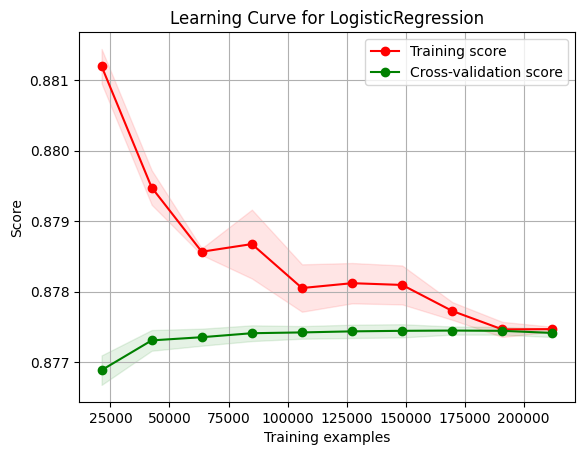

In [10]:
log_reg = LogisticRegression(n_jobs=-1, max_iter=1000)

train_sizes, train_scores, test_scores = learning_curve(
    log_reg, X_train_transformed, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve for LogisticRegression")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")

plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.legend(loc="best")
plt.show()


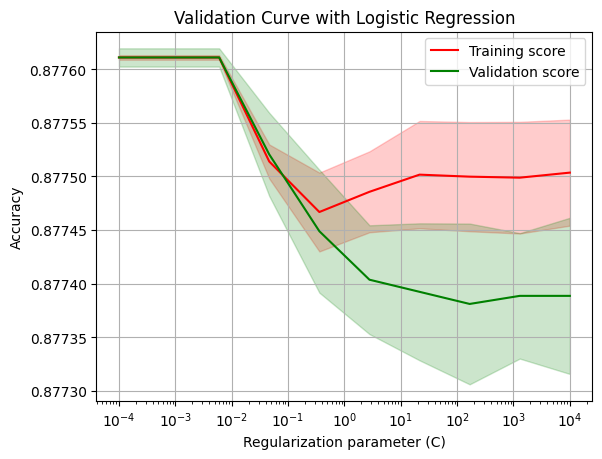

In [5]:
# from the best models

log_reg = LogisticRegression(n_jobs=-1, max_iter=1000)

param_range = np.logspace(-4, 4, 10)

train_scores, valid_scores = validation_curve(
    log_reg, X_train_transformed, y_train, param_name="C", param_range=param_range, scoring="accuracy", n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.figure()
plt.semilogx(param_range, train_mean, label="Training score", color="r")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)
plt.semilogx(param_range, valid_mean, label="Validation score", color="g")
plt.fill_between(param_range, valid_mean - valid_std, valid_mean + valid_std, color="g", alpha=0.2)

plt.title("Validation Curve with Logistic Regression")
plt.xlabel("Regularization parameter (C)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()

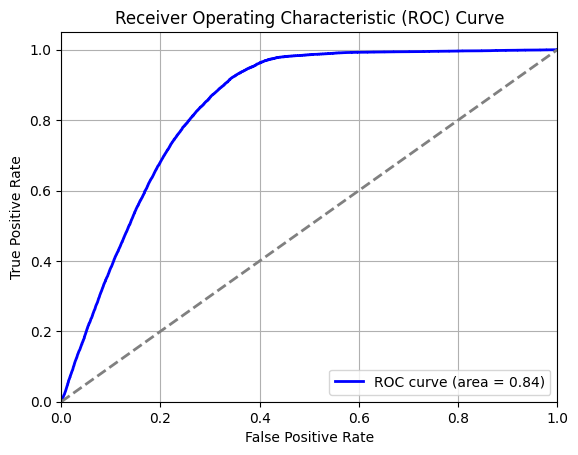

In [7]:
log_reg = LogisticRegression(n_jobs=-1, max_iter=1000)
log_reg.fit(X_train_transformed, y_train)

y_pred_prob = log_reg.predict_proba(X_test_transformed)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="b", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### KNN

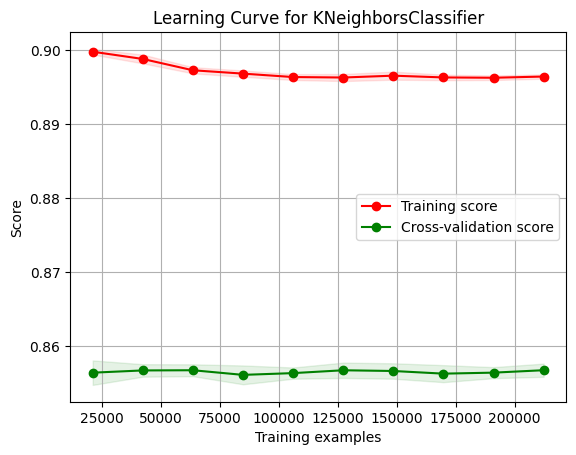

In [11]:
knn_model = KNeighborsClassifier(n_neighbors=5)

train_sizes, train_scores, test_scores = learning_curve(
    knn_model, X_train_transformed, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve for KNeighborsClassifier")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")

plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.legend(loc="best")
plt.show()


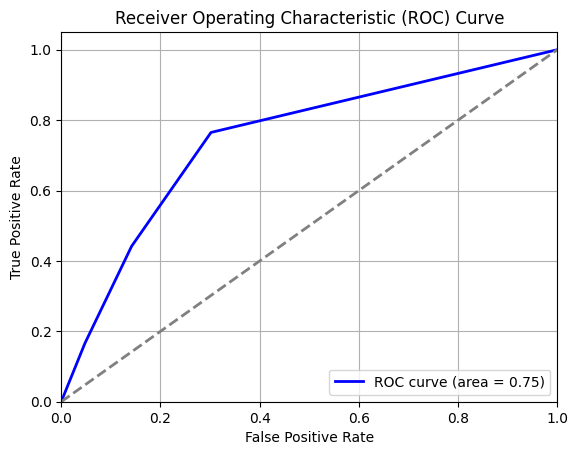

In [14]:
knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train_transformed, y_train)

y_pred_prob = knn_model.predict_proba(X_test_transformed)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="b", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Results

In [144]:
model_scores_df.head(50)

,Model,Data,Accuracy,F1 Score
0,LogisticRegression,Preprocessed Data,0.878,0.821
1,LogisticRegression,Oversampled Data,0.678,0.733
2,LogisticRegression,Undersampled Data,0.681,0.736
3,LogisticRegression,PCA Data,0.877,0.821
4,NAIVE BAYES,Preprocessed Data,0.731,0.775
5,NAIVE BAYES,Oversampled Data,0.692,0.745
6,NAIVE BAYES,Undersampled Data,0.693,0.746
7,NAIVE BAYES,PCA Data,0.878,0.820
8,K-Nearest Neighbors (KNN),Preprocessed Data,0.856,0.835
9,K-Nearest Neighbors (KNN),Oversampled Data,0.746,0.784


In [145]:
best_score = model_scores_df['Accuracy'].max()
model_scores_df[model_scores_df['Accuracy'] == best_score]

,Model,Data,Accuracy,F1 Score
0,LogisticRegression,Preprocessed Data,0.878,0.821
7,NAIVE BAYES,PCA Data,0.878,0.820
13,Random Forest Classifier,Preprocessed Data,0.878,0.820
16,XGBoost Classifier,Preprocessed Data,0.878,0.821
19,XGBoost Classifier,PCA Data,0.878,0.823


In [146]:
best_score = model_scores_df['F1 Score'].max()
model_scores_df[model_scores_df['F1 Score'] == best_score]

,Model,Data,Accuracy,F1 Score
8,K-Nearest Neighbors (KNN),Preprocessed Data,0.856,0.835
11,K-Nearest Neighbors (KNN),PCA Data,0.863,0.835


In [147]:
model_scores_df.to_csv("results.csv")

## Save Best Model

XGBoost Classifier which trained on	PCA Data

In [148]:
joblib.dump(xgb, "best_model.pkl") 

['best_model.pkl']

In [ ]:
# best_model = joblib.load("best_model.pkl")